In [1]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate

plt.rcParams["figure.figsize"] = [14, 5]
# sns.set(rc={'figure.figsize':(14,5)})

color_palette = {
    'MVERegression': '#1f77b4',  # Blue
    'QuantileRegression': '#ff7f0e',  # Orange
    'DKLRegression': '#2ca02c',  # Green
    'LaplaceRegresion': '#d62728',  # Red
    'DeepEnsembleRegression': '#9467bd',  # Purple
    'MCDropoutRegression': '#8c564b',  # Brown
    'SWAGRegression': '#e377c2',  # Pink
    'BNN_VI_ELBO_Regression': '#7f7f7f',  # Gray
    'DER': '#bcbd22',  # Lime
    'DUERegression': '#17becf',  # Teal
    'DeterministicRegression': '#aec7e8', # Light Blue
    'ConformalQR': '#ffbb78',  # Light Orange
    "CARDRegression": "#98df8a"
}

%load_ext autoreload
%autoreload 2

In [2]:
# specify directories to include in analysis
directories = [
    "/p/project/hai_uqmethodbox/experiment_output/keep_reg",
]
paths = [file for directory in directories for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))]



# selective prediction threshold
SELECTIVE_THRESH = 9

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
CLASS_BINS = {
    "tropical_depression": (0, 33),
    "tropical_storm": (34, 63),
    "hurr_1": (64, 82),
    "hurr_2": (83, 95),
    "hurr_3": (96, 112),
    "hurr_4": (113, 136),
    "hurr_5": (137, np.inf),
}
BIN_EDGES = [0] + [v[1] for v in CLASS_BINS.values()]
CLASS_LABELS = list(CLASS_BINS.keys())

In [3]:
paths

['/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DeterministicRegression_12-13-2023_13-37-13-856844/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DeterministicRegression_12-13-2023_13-37-13-856844/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DeterministicRegression_12-13-2023_13-37-13-856844/preds.csv',
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_QuantileRegression_12-12-2023_21-05-35-511871/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_QuantileRegression_12-12-2023_21-05-35-511871/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_QuantileRegression_12-12-2023_21-05-35-511871/preds.csv',
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_MCDropoutRegression_12-11-2023_17-52-33-292670/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_MCDropoutRegression_12-11-2023_17-52-33-29

## Util functions

In [4]:
def get_target_normalization_params(config):
    """Get the target normalization parameters from the datamodule
    
    Args:
        config: hydra config object

    Returns:
        tuple: (target_mean, target_std)
    """
    dm = instantiate(config.datamodule)
    return dm.target_mean.item(), dm.target_std.item()

def get_normalization_params_from_df(pred_path):
    config = OmegaConf.load(os.path.join(pred_path, 'config.yaml'))
    target_mean, target_std = get_target_normalization_params(config)
    return {pred_path: {"target_mean": target_mean, "target_std": target_std}}


def get_normalization_params_from_df_wrapper(path):
    try:
        return get_normalization_params_from_df(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

def compute_normalization_params_in_parallel(paths, num_processes):
    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap(get_normalization_params_from_df_wrapper, paths), total=len(paths)))
    results = {k: v for result in results if result is not None for k, v in result.items()}
    return results

num_processes = 8
dir_paths = list(set([os.path.dirname(path) for path in paths]))
NORMALIZATION_PARAMS = compute_normalization_params_in_parallel(dir_paths, num_processes)

  0%|          | 0/8 [00:00<?, ?it/s]

Num samples: 46589
Num samples: 46589
Num samples: 46589
Num samples: 46589
Num samples: 46589
Num samples: 46589
Num samples: 46589
Num samples: 46589


100%|██████████| 8/8 [00:41<00:00,  5.18s/it]


In [5]:
NORMALIZATION_PARAMS

{'/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030': {'target_mean': 61.754425048828125,
  'target_std': 25.530269622802734},
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DeterministicRegression_12-13-2023_13-37-13-856844': {'target_mean': 61.754425048828125,
  'target_std': 25.530269622802734},
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DUERegression_12-11-2023_17-52-33-292677': {'target_mean': 61.754425048828125,
  'target_std': 25.530269622802734},
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_QuantileRegression_12-12-2023_21-05-35-511871': {'target_mean': 61.754425048828125,
  'target_std': 25.530269622802734},
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_MVERegression_12-11-2023_17-52-33-292682': {'target_mean': 61.754425048828125,
  'target_std': 25.530269622802734},
 '/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DeepEnsembleRegressio

In [6]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]
        
        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, '%m-%d-%Y')
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = path.replace("preds.csv", "config.yaml")
        exp_dict["metric_path"] = os.path.join(os.path.dirname(path), "csv_logs", "version_0", "metrics.csv")
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df

overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,DeterministicRegression,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...
1,DeterministicRegression,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...
2,DeterministicRegression,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...
3,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...
4,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...
5,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...
6,MCDropoutRegression,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...
7,MCDropoutRegression,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...
8,MCDropoutRegression,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...
9,DeepEnsembleRegression,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...,/p/project/hai_uqmethodbox/experiment_output/k...


In [7]:
empty_result = {'accuracy': {'mae': np.nan, 'rmse': np.nan, 'mdae': np.nan, 'marpd': np.nan, 'r2': np.nan, 'corr': np.nan}, 'avg_calibration': {'rms_cal': np.nan, 'ma_cal': np.nan, 'miscal_area': np.nan}, 'sharpness': {'sharp': np.nan}, 'scoring_rule': {'nll': np.nan, 'crps': np.nan, 'check': np.nan, 'interval': np.nan}}
def compute_metrics_for_predictions(csv_path: str, selective_pred: bool, normalized: bool = False) -> pd.DataFrame:
    """Compute metrics for prediction file.

    Args:
        save_dir: path_to_csv
        selective_pred: whether or not to apply selective prediction

    Returns:
        dataframe with computed metrics
    """
    pred_df = pd.read_csv(csv_path)

    # get normalization parameters
    TARGET_MEAN, TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_mean"], NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_std"]
                                                              
    # unnormalize data
    if not normalized:
        pred_df["pred"] = (pred_df["pred"] * TARGET_STD) + TARGET_MEAN
        pred_df["target"] = (pred_df["target"] * TARGET_STD) + TARGET_MEAN

    bin_edges = [0] + [v[1] for v in CLASS_BINS.values()]

    # Apply the storm category
    pred_df['storm_category'] = pd.cut(pred_df['target'], bins=bin_edges, labels=CLASS_LABELS, right=False)
    # count number of observations per category
    count_per_cat = pred_df.groupby("storm_category", observed=False)["pred"].count()

    if "pred_uct" in pred_df.columns:

        if not normalized:
            pred_df["pred_uct"] = pred_df["pred_uct"] * TARGET_STD

        if selective_pred:
            # Filter the DataFrame to exclude the top 10% highest values
            pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_THRESH]
            # number of observations per category afterwards
            count_per_cat = pred_df.groupby("storm_category", observed=False)["pred"].count()

        if len(pred_df) > 0:  
            uq_metrics = uct.metrics.get_all_metrics(
                pred_df["pred"].values.squeeze(),
                pred_df["pred_uct"].values.squeeze(),
                pred_df["target"].values.squeeze(),
                verbose=False,
            )
        else:
            # TODO: What to do if all metrics are removed
            uq_metrics = empty_result
        # categories when predictive uncertainty is present
        uq_metric_categories = ["scoring_rule", "avg_calibration", "sharpness", "accuracy"]

    else:
        # categories when no predictive uncertainty is present
        uq_metric_categories = ["accuracy"]
        uq_metrics = {"accuracy": uct.metrics.get_all_accuracy_metrics(pred_df["pred"].values.squeeze(), pred_df["target"].values.squeeze())}

    # collect metrics
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}

    # mulit column df holding the results
    df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T

    # drop multilevel
    df.columns = df.columns.droplevel(0)

    # case if empty results have to handle manually since dict of nan just creates empty df
    if df.empty:
        # Flatten the dictionary keys
        flattened_keys = [f'{inner_key}' for outer_key, inner_dict in empty_result.items() for inner_key in inner_dict.keys()]
        # Create DataFrame
        df = pd.DataFrame(columns=flattened_keys)
        # Fill DataFrame with NaNs
        df.loc[0] = np.nan

    df["split"] = csv_path.split(os.sep)[-1].split(".")[0]
    df["pred_path"] = csv_path

    # count 
    count_df = pd.DataFrame(count_per_cat).transpose().reset_index()
    count_df = count_df[count_df.columns.intersection(CLASS_LABELS)]
    count_df["count_total"] = count_df.sum(axis=1)
    df = pd.concat([df, count_df], axis=1)
    return df

In [8]:
def compute_metrics_for_predictions_wrapper(path, selective_pred, normalised):
    try:
        return compute_metrics_for_predictions(path, selective_pred, normalised)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None
    
def compute_uncertainty_df(overview_df):
    def parallel_process(paths: List[str], num_processes: int, selective_pred: bool, normalised: bool):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        # result_dfs = pool.starmap(compute_metrics_for_predictions, [(path, selective_pred, normalised) for path in paths])
        results = pool.starmap(compute_metrics_for_predictions_wrapper, [(path, selective_pred, normalised) for path in paths])
        # Filter out None results
        result_dfs = [result for result in results if result is not None]
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        combined_df = pd.concat(result_dfs, ignore_index=True)
        return combined_df

    # Assuming 'df' is your original DataFrame with the path column
    # Extract the paths from the DataFrame column
    paths = overview_df['pred_path'].tolist()

    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities

    # Call the parallel_process function to execute the processing in parallel
    uqmetric_df = parallel_process(paths, num_processes, selective_pred=False, normalised=False)
    selective_df = parallel_process(paths, num_processes, selective_pred=True, normalised=False)

    # merge model name column
    uqmetric_df = pd.merge(left=uqmetric_df, right=overview_df[["pred_path", "uqmethod"]], how="left", left_on="pred_path", right_on="pred_path")
    selective_df = pd.merge(left=selective_df, right=overview_df[["pred_path", "uqmethod"]], how="left", left_on="pred_path", right_on="pred_path")

    return uqmetric_df, selective_df


uq_metric_df, selective_df = compute_uncertainty_df(overview_df)

uq_metric_df, selective_df

 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics (1/n) Calculating accuracy metrics



(          mae       rmse      mdae      marpd        r2      corr  \
 0    7.591992   9.798322  6.256293  13.166009  0.839778  0.916784   
 1    1.519853   1.973517  1.224464   2.605987  0.994104  0.997178   
 2    7.701325  10.256693  5.969879  13.370729  0.801679  0.895459   
 3    8.296742  10.443477  6.965865  14.549443  0.816469  0.904652   
 4    4.230883   5.528176  3.383921   7.236334  0.953633  0.977113   
 5    8.357515  10.894114  6.804801  14.568846  0.776263  0.882358   
 6   10.102321  12.944610  8.322823  17.112713  0.683767  0.858168   
 7    5.738528   7.587897  4.437093   9.415418  0.914364  0.968241   
 8    9.623664  12.386779  7.701772  16.349122  0.710751  0.864722   
 9    6.832249   9.143517  5.144725  10.724730  0.880393  0.953036   
 10   5.101452   6.850979  3.881209   8.713432  0.926014  0.962664   
 11  11.428135  15.106168  8.783873  18.880914  0.569807  0.762006   
 12   8.600994  11.110872  6.929387  14.661889  0.795096  0.892866   
 13   5.885300   7.8

In [9]:
with pd.option_context('display.max_colwidth', None):
    display(uq_metric_df[uq_metric_df["uqmethod"]=="BNN_VI_ELBO_Regression"][["pred_path","split", "rmse", "nll", "crps", "sharp"]])

,pred_path,split,rmse,nll,crps,sharp
21,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_BNN_VI_ELBO_Regression_12-13-2023_13-37-13-847598/preds_val.csv,preds_val,12.652728,4.195632,6.821644,9.703625
22,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_BNN_VI_ELBO_Regression_12-13-2023_13-37-13-847598/preds_train.csv,preds_train,8.015147,3.344742,4.095033,9.786822
23,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_BNN_VI_ELBO_Regression_12-13-2023_13-37-13-847598/preds.csv,preds,13.399470,4.229333,7.176721,9.291710


# Diff Selective Prediction Effect

This Table shows the performance improvement in metrics after applying selective prediction.

In [10]:
diff_df = pd.DataFrame()

# Iterate over each column in the dataframes
for column in uq_metric_df.columns:
    # Check if the column contains numerical values
    if pd.api.types.is_numeric_dtype(uq_metric_df[column]):
        # Assign the difference to the new dataframe
        diff_df[column] = uq_metric_df[column] - selective_df[column]
    else:
        # If the column contains non-numerical values, assign the values from df1 to the new dataframe
        diff_df[column] = uq_metric_df[column]

display(diff_df[diff_df["split"]=="preds"][["uqmethod", "split", "nll", "sharp", "mae", "rmse", "pred_path"]])

,uqmethod,split,nll,sharp,mae,rmse,pred_path
2,DeterministicRegression,preds,NaN,NaN,0.000000,0.000000,/p/project/hai_uqmethodbox/experiment_output/k...
5,QuantileRegression,preds,0.002603,0.144784,0.126115,0.186713,/p/project/hai_uqmethodbox/experiment_output/k...
8,MCDropoutRegression,preds,0.607547,4.932056,5.769675,7.113260,/p/project/hai_uqmethodbox/experiment_output/k...
11,DeepEnsembleRegression,preds,0.740192,6.200748,7.467779,9.084662,/p/project/hai_uqmethodbox/experiment_output/k...
14,MVERegression,preds,0.131954,1.930980,1.332861,1.962551,/p/project/hai_uqmethodbox/experiment_output/k...
17,DUERegression,preds,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/k...
20,DKLRegression,preds,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/k...
23,BNN_VI_ELBO_Regression,preds,0.107829,2.215808,1.436005,2.168674,/p/project/hai_uqmethodbox/experiment_output/k...


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'DeterministicRegression'),
  Text(1, 0, 'QuantileRegression'),
  Text(2, 0, 'MCDropoutRegression'),
  Text(3, 0, 'DeepEnsembleRegression'),
  Text(4, 0, 'MVERegression'),
  Text(5, 0, 'DUERegression'),
  Text(6, 0, 'DKLRegression'),
  Text(7, 0, 'BNN_VI_ELBO_Regression')])

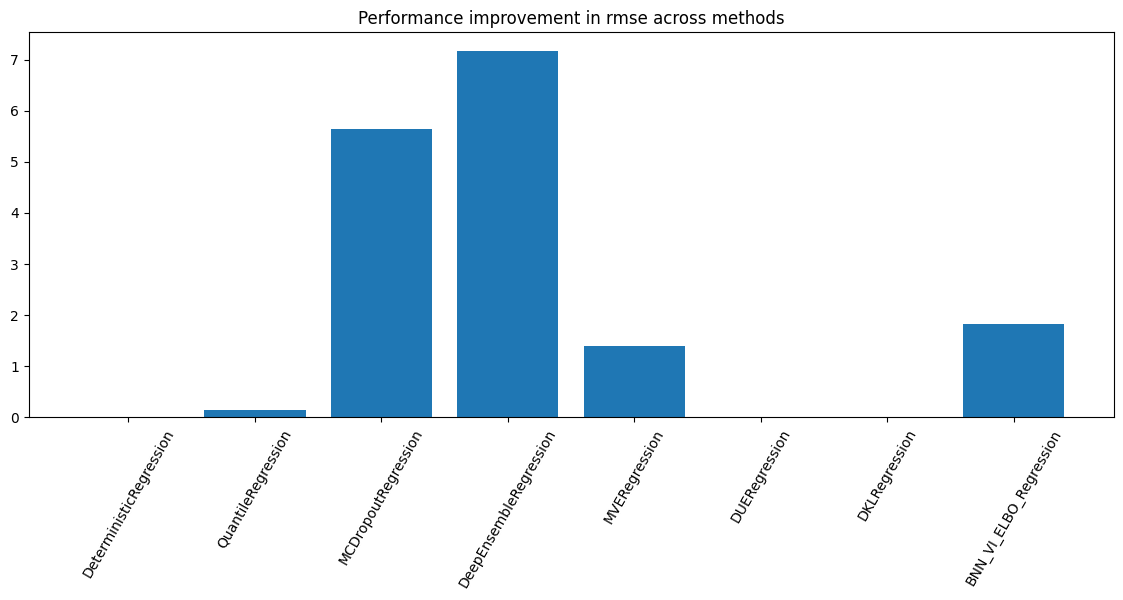

In [11]:
metric = "rmse"
diff_train = diff_df[diff_df["split"]=="preds_train"].reset_index(drop=True)
diff_test = diff_df[diff_df["split"]=="preds_val"].reset_index(drop=True)
fig, ax = plt.subplots(1)
ax.bar(diff_test["uqmethod"].values, diff_test[metric].values)
plt.title(f"Performance improvement in {metric} across methods")
plt.xticks(rotation=60)

In [12]:
uq_metric_df

,mae,rmse,mdae,marpd,r2,corr,split,pred_path,tropical_depression,tropical_storm,...,count_total,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,uqmethod
0,7.591992,9.798322,6.256293,13.166009,0.839778,0.916784,preds_val,/p/project/hai_uqmethodbox/experiment_output/k...,0,4847,...,7655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DeterministicRegression
1,1.519853,1.973517,1.224464,2.605987,0.994104,0.997178,preds_train,/p/project/hai_uqmethodbox/experiment_output/k...,0,24277,...,38934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DeterministicRegression
2,7.701325,10.256693,5.969879,13.370729,0.801679,0.895459,preds,/p/project/hai_uqmethodbox/experiment_output/k...,0,18227,...,26733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DeterministicRegression
3,8.296742,10.443477,6.965865,14.549443,0.816469,0.904652,preds_val,/p/project/hai_uqmethodbox/experiment_output/k...,0,4032,...,6265,4.423422,6.239203,3.148443,35.208731,0.217751,0.194864,0.196832,5.905790,QuantileRegression
4,4.230883,5.528176,3.383921,7.236334,0.953633,0.977113,preds_train,/p/project/hai_uqmethodbox/experiment_output/k...,0,25092,...,40324,3.060872,2.999592,1.514618,14.761082,0.012774,0.011668,0.011786,5.890229,QuantileRegression
5,8.357515,10.894114,6.804801,14.568846,0.776263,0.882358,preds,/p/project/hai_uqmethodbox/experiment_output/k...,0,18227,...,26733,4.514008,6.313677,3.185357,36.263235,0.215635,0.192843,0.194791,5.861306,QuantileRegression
6,10.102321,12.944610,8.322823,17.112713,0.683767,0.858168,preds_val,/p/project/hai_uqmethodbox/experiment_output/k...,0,5108,...,7560,3.936816,7.145963,3.608306,34.996070,0.032432,0.030112,0.030417,13.871832,MCDropoutRegression
7,5.738528,7.587897,4.437093,9.415418,0.914364,0.968241,preds_train,/p/project/hai_uqmethodbox/experiment_output/k...,0,24016,...,39029,3.640063,4.607256,2.326213,25.221888,0.220594,0.197652,0.199648,13.731698,MCDropoutRegression
8,9.623664,12.386779,7.701772,16.349122,0.710751,0.864722,preds,/p/project/hai_uqmethodbox/experiment_output/k...,0,18227,...,26733,3.876603,6.769877,3.418421,33.248626,0.047018,0.039560,0.039959,13.621179,MCDropoutRegression
9,6.832249,9.143517,5.144725,10.724730,0.880393,0.953036,preds_val,/p/project/hai_uqmethodbox/experiment_output/k...,0,3960,...,7245,3.754717,5.326558,2.689436,28.528346,0.198486,0.178582,0.180386,14.969923,DeepEnsembleRegression


The number of samples being removed per category as a percentage.

In [13]:
sample_remain_pct = (uq_metric_df[CLASS_LABELS+["count_total"]] - selective_df[CLASS_LABELS+["count_total"]]) / uq_metric_df[CLASS_LABELS+["count_total"]]
sample_remain_pct.insert(0, ("split"), uq_metric_df["split"])
sample_remain_pct.insert(0, ("UQ Method"), uq_metric_df["uqmethod"])

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'DeterministicRegression'),
  Text(1, 0, 'QuantileRegression'),
  Text(2, 0, 'MCDropoutRegression'),
  Text(3, 0, 'DeepEnsembleRegression'),
  Text(4, 0, 'MVERegression'),
  Text(5, 0, 'DUERegression'),
  Text(6, 0, 'DKLRegression'),
  Text(7, 0, 'BNN_VI_ELBO_Regression')])

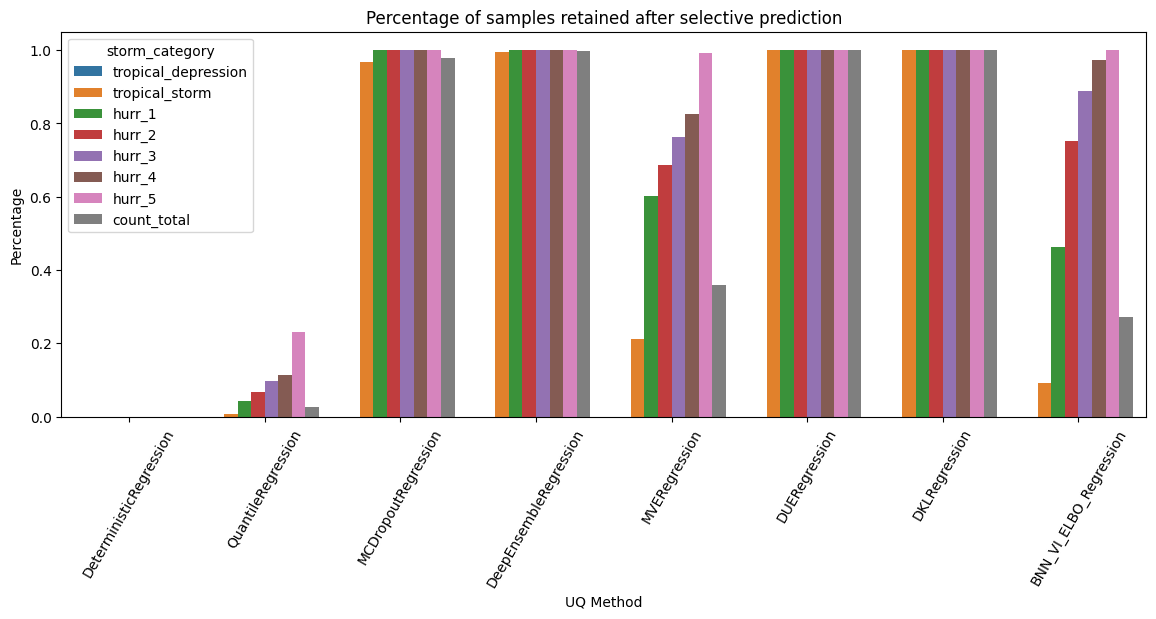

In [14]:
train_count = sample_remain_pct[sample_remain_pct["split"]=="preds_train"].reset_index(drop=True)
train_count = pd.melt(train_count, id_vars="UQ Method", value_vars=CLASS_LABELS+["count_total"], var_name="storm_category")
test_count = sample_remain_pct[sample_remain_pct["split"]=="preds"].reset_index(drop=True)
test_count = pd.melt(test_count, id_vars="UQ Method", value_vars=CLASS_LABELS+["count_total"], var_name="storm_category")
fig, ax = plt.subplots(1)
sns.barplot(x="UQ Method", y="value", hue="storm_category", data=test_count)
plt.ylabel("Percentage")
plt.title("Percentage of samples retained after selective prediction")
plt.xticks(rotation=60)

# All preds in a single DF

In [15]:
overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]
# test_df = overview_df[overview_df["split"]=="preds.csv"].reset_index(drop=True)

all_test_pred_df = []
for idx, row in overview_df.iterrows():
    pred_df = pd.read_csv(row["pred_path"])
    pred_df["uqmethod"] = row["uqmethod"]
    pred_df["split"] = row["split"]
    pred_df["pred_path"] = row["pred_path"]
    # pred_df['base_dir'] = pred_df['pred_path'].apply(os.path.dirname)
    # pred_df["target_mean"], pred_df["target_std"] = pred_df["pred_path"].apply(get_normalization_params_from_df)
    # pred_df.drop(columns="base_dir", inplace=True)
    all_test_pred_df.append(pred_df)

from scipy import stats
# test_df = overview_df[overview_df["split"]=="preds"]

all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)

# get normalization parameters and put them into df columns
# no apply them to the df
# all_test_pred_df['base_dir'] = all_test_pred_df['pred_path'].apply(os.path.dirname)
# grouped = all_test_pred_df.groupby('base_dir')['pred_path'].first().apply(get_normalization_params_from_df)
# grouped_df = grouped.reset_index()
# grouped_df.columns = ['base_dir', 'target_mean', 'target_std']
# all_test_pred_df = pd.merge(all_test_pred_df, grouped_df, on='base_dir', how='left')
# all_test_pred_df = all_test_pred_df.drop(columns='base_dir')
# all_test_pred_df[["target_mean", "target_std"]] = all_test_pred_df["pred_path"].apply(get_normalization_params_from_df)

def get_normalization_params(group):
    pred_path = group['pred_path'].iloc[0]
    TARGET_MEAN, TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_mean"], NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_std"]
    group['target_mean'] = TARGET_MEAN
    group['target_std'] = TARGET_STD
    return group

all_test_pred_df = all_test_pred_df.groupby('pred_path').apply(get_normalization_params)

# normalize
all_test_pred_df["pred"] = (all_test_pred_df["pred"] * all_test_pred_df["target_std"]) + all_test_pred_df["target_mean"]
all_test_pred_df["target"] = (all_test_pred_df["target"] * all_test_pred_df["target_std"]) + all_test_pred_df["target_mean"]
all_test_pred_df["pred_uct"] = all_test_pred_df["pred_uct"] * all_test_pred_df["target_std"]

all_test_pred_df['storm_category'] = pd.cut(all_test_pred_df['target'], bins=BIN_EDGES, labels=CLASS_LABELS, right=False)
all_test_pred_df["mse"] = (all_test_pred_df["pred"] - all_test_pred_df["target"])**2
all_test_pred_df["mae"] = np.abs(all_test_pred_df["pred"] - all_test_pred_df["target"])
all_test_pred_df["nll"] = -1 * stats.norm.logpdf(all_test_pred_df["pred"] - all_test_pred_df["target"], scale=all_test_pred_df["pred_uct"])

# date
pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

# Extract dates and create a new column
all_test_pred_df['date'] = all_test_pred_df['pred_path'].str.extract(pattern)

# Convert the new_date_column to datetime format
all_test_pred_df['date'] = pd.to_datetime(all_test_pred_df['date'], format='%m-%d-%Y_%H-%M')

all_test_pred_df = all_test_pred_df.reset_index(drop=True)
all_test_pred_df = all_test_pred_df.dropna(subset=["mse", "mae"], how='any')
all_test_pred_df

,pred,target,uqmethod,split,pred_path,pred_uct,lower_quant,upper_quant,aleatoric_uct,epistemic_uct,target_mean,target_std,storm_category,mse,mae,nll,date
0,43.751102,34.999999,BNN_VI_ELBO_Regression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/k...,7.817690,NaN,NaN,NaN,0.306213,61.754425,25.53027,tropical_storm,76.581794,8.751102,3.601853,NaT
1,45.829516,34.999999,BNN_VI_ELBO_Regression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/k...,7.816640,NaN,NaN,NaN,0.306171,61.754425,25.53027,tropical_storm,117.278429,10.829517,3.934921,NaT
2,45.764107,40.000000,BNN_VI_ELBO_Regression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/k...,7.595227,NaN,NaN,NaN,0.297499,61.754425,25.53027,tropical_storm,33.224936,5.764108,3.234432,NaT
3,47.619356,40.000000,BNN_VI_ELBO_Regression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/k...,7.715187,NaN,NaN,NaN,0.302198,61.754425,25.53027,tropical_storm,58.054594,7.619357,3.449785,NaT
4,49.573534,40.000000,BNN_VI_ELBO_Regression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/k...,7.403105,NaN,NaN,NaN,0.289974,61.754425,25.53027,tropical_storm,91.652563,9.573535,3.756993,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584759,46.510378,47.000000,QuantileRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/k...,5.473141,-0.886085,-0.336611,0.214378,NaN,61.754425,25.53027,tropical_storm,0.239730,0.489622,2.622793,NaT
584760,47.431160,42.000000,QuantileRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/k...,6.294994,-0.963526,-0.331543,0.246570,NaN,61.754425,25.53027,tropical_storm,29.497501,5.431160,3.130883,NaT
584761,44.092937,40.000000,QuantileRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/k...,5.969026,-1.020134,-0.420875,0.233802,NaN,61.754425,25.53027,tropical_storm,16.752133,4.092937,2.940612,NaT
584762,44.479928,37.000000,QuantileRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/k...,4.639590,-0.933786,-0.467996,0.181729,NaN,61.754425,25.53027,tropical_storm,55.949332,7.479929,3.753152,NaT


In [16]:
all_test_pred_df[all_test_pred_df["pred_uct"].isna()]

,pred,target,uqmethod,split,pred_path,pred_uct,lower_quant,upper_quant,aleatoric_uct,epistemic_uct,target_mean,target_std,storm_category,mse,mae,nll,date
291476,35.806919,34.999999,DeterministicRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/k...,NaN,NaN,NaN,NaN,NaN,61.754425,25.53027,tropical_storm,0.651120,0.806920,NaN,NaT
291477,38.470113,34.999999,DeterministicRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/k...,NaN,NaN,NaN,NaN,NaN,61.754425,25.53027,tropical_storm,12.041688,3.470114,NaN,NaT
291478,39.697407,40.000000,DeterministicRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/k...,NaN,NaN,NaN,NaN,NaN,61.754425,25.53027,tropical_storm,0.091563,0.302593,NaN,NaT
291479,42.014947,40.000000,DeterministicRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/k...,NaN,NaN,NaN,NaN,NaN,61.754425,25.53027,tropical_storm,4.060010,2.014947,NaN,NaT
291480,42.766318,40.000000,DeterministicRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/k...,NaN,NaN,NaN,NaN,NaN,61.754425,25.53027,tropical_storm,7.652514,2.766318,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364793,38.528510,38.000000,DeterministicRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/k...,NaN,NaN,NaN,NaN,NaN,61.754425,25.53027,tropical_storm,0.279323,0.528510,NaN,NaT
364794,39.015212,37.000000,DeterministicRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/k...,NaN,NaN,NaN,NaN,NaN,61.754425,25.53027,tropical_storm,4.061081,2.015212,NaN,NaT
364795,40.519867,34.999999,DeterministicRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/k...,NaN,NaN,NaN,NaN,NaN,61.754425,25.53027,tropical_storm,30.468942,5.519868,NaN,NaT
364796,39.750040,33.999999,DeterministicRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/k...,NaN,NaN,NaN,NaN,NaN,61.754425,25.53027,tropical_storm,33.062971,5.750041,NaN,NaT


In [17]:
all_test_pred_df[all_test_pred_df["pred_uct"].isna()]["uqmethod"].unique()

array(['DeterministicRegression'], dtype=object)

In [18]:
all_test_pred_df.target.min()

33.99999918491821

## Dataframe with Metrics per Category

In [19]:
group_cols = ["uqmethod", "pred_path", "storm_category"]
category_df = all_test_pred_df.groupby(by=group_cols, observed=False)[["mse", "mae", "nll", "pred_uct"]].mean()
category_df.reset_index(inplace=True)
category_df.rename(columns={"pred_uct": "sharpness"}, inplace=True)
category_df["rmse"] = category_df["mse"] ** 0.5
category_df['split'] = category_df['pred_path'].str.rsplit('/', n=1).str[-1].str.rsplit(".").str[0]
category_df["contains"] = [x[0] in x[1] for x in zip(category_df['uqmethod'], category_df['pred_path'])]
category_df = category_df[category_df["contains"]==True]

category_df = category_df[~((category_df['uqmethod'] == 'MCDropoutRegression') & category_df['rmse'].isna())]
category_df = category_df[~((category_df['uqmethod'] == 'DKLRegression') & category_df['rmse'].isna())]
# category_df = category_df[~((category_df['uqmethod'] == 'BaseModel') & category_df['rmse'].isna())]

del category_df["contains"]
# compute other metrics of interest
quantile = 0.95
result = all_test_pred_df[all_test_pred_df["uqmethod"]!="DeterministicRegression"].groupby(group_cols, observed=False).apply(lambda x: uct.get_proportion_in_interval(x["pred"].values, x['pred_uct'].values, x['target'].values, quantile=quantile)).reset_index()
result.rename(columns={0: f"proportion_in_{quantile}_interval"}, inplace=True)

category_df = pd.merge(category_df, result, how="left", left_on=group_cols, right_on=group_cols)

columns_to_check = ["mse", "mae", "nll", "sharpness", "rmse"]
category_df = category_df.dropna(subset=columns_to_check)
category_df

,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,rmse,split,proportion_in_0.95_interval
1,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/k...,tropical_storm,70.316894,6.740455,3.564107,7.239834,8.385517,preds,0.910792
2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/k...,hurr_1,188.184091,11.564375,4.731176,9.460393,13.718021,preds,0.712168
3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/k...,hurr_2,415.246388,17.409538,6.146047,11.768305,20.377595,preds,0.600758
4,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/k...,hurr_3,677.074143,21.097006,7.181260,13.792827,26.020648,preds,0.650140
5,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/k...,hurr_4,879.753449,24.305823,6.500642,16.516074,29.660638,preds,0.736494
...,...,...,...,...,...,...,...,...,...,...
157,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/k...,hurr_1,137.630662,9.680583,4.919737,6.589319,11.731610,preds_val,0.660764
158,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/k...,hurr_2,195.665381,11.427518,4.842882,7.393276,13.988044,preds_val,0.676113
159,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/k...,hurr_3,209.282284,11.586216,4.814331,7.195268,14.466592,preds_val,0.677778
160,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/k...,hurr_4,101.585424,7.921155,3.914364,6.839823,10.078959,preds_val,0.794118


In [20]:
with pd.option_context('display.max_colwidth', None):
    display(category_df[category_df["uqmethod"]=="DKLRegression"])


,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,rmse,split,proportion_in_0.95_interval
21,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030/preds.csv,tropical_storm,82.342375,6.964974,3.695309,12.175763,9.074270,preds,0.983815
22,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030/preds.csv,hurr_1,200.908010,11.567582,4.097361,12.175515,14.174202,preds,0.906287
23,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030/preds.csv,hurr_2,255.793882,13.119386,4.282112,12.161509,15.993558,preds,0.866197
24,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030/preds.csv,hurr_3,411.455434,15.232669,4.802252,12.186707,20.284364,preds,0.780028
25,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030/preds.csv,hurr_4,414.690455,15.170620,4.818668,12.174975,20.363950,preds,0.782800
26,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030/preds.csv,hurr_5,431.624713,15.284205,4.872836,12.201596,20.775580,preds,0.782609
27,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030/preds_train.csv,tropical_storm,10.146277,2.391787,3.450435,12.205502,3.185322,preds_train,0.999915
28,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030/preds_train.csv,hurr_1,13.877386,2.890852,3.467906,12.298537,3.725236,preds_train,1.000000
29,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030/preds_train.csv,hurr_2,11.152000,2.662825,3.454685,12.158588,3.339461,preds_train,1.000000
30,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/keep_reg/cyclone_DKLRegression_12-08-2023_17-19-17-715030/preds_train.csv,hurr_3,11.252455,2.618553,3.455484,12.164754,3.354468,preds_train,1.000000


In [21]:
# Make latex table
metric_columns = ["rmse", "nll"]

table_labels = category_df["storm_category"].unique()
print(table_labels)
columns = pd.MultiIndex.from_product([table_labels, metric_columns])
combined_df = pd.DataFrame(columns=columns)

latex_df = category_df[category_df["split"]=="preds_val"]

# combined_df["uqmethod"] = tail_and_gap_selective_df["uqmethod"].unique()
for split in table_labels:
    split_df = latex_df[latex_df["storm_category"]==split]
    for metric in metric_columns:
        combined_df[(split, metric)] = split_df[metric].values

combined_df.insert(0, ("", "uqmethod"), latex_df["uqmethod"].unique())
combined_df= combined_df.round(3)
# print(combined_df)

def as_latex_output(combined_df):
    combined_df = combined_df.round(3)
    # print(combined_df.max())
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.3f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        # latex_column = column.replace("_", "\\_")
        # latex_output = latex_output.replace(column, latex_column)

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("rmse", "rmse $\downarrow$")
    latex_output = latex_output.replace("nll", "nll $\downarrow$")
    # latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrr}", "l|cc|cc|cc|cc|cc")
    latex_output = latex_output.replace("\multicolumn{2}{r}", "\multicolumn{2}{c}")
    latex_output = latex_output.replace("\textbf{BNN\_VI\_ELBO}", "BNN\_VI\_ELBO")
    return latex_output

latex_table = as_latex_output(combined_df)
print(latex_table)

['tropical_storm', 'hurr_1', 'hurr_2', 'hurr_3', 'hurr_4', 'hurr_5']
Categories (7, object): ['tropical_depression' < 'tropical_storm' < 'hurr_1' < 'hurr_2' < 'hurr_3' < 'hurr_4' < 'hurr_5']
\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{tropical\_storm} & \multicolumn{2}{c}{hurr\_1} & \multicolumn{2}{c}{hurr\_2} & \multicolumn{2}{c}{hurr\_3} & \multicolumn{2}{c}{hurr\_4} & \multicolumn{2}{c}{hurr\_5} \\
uqmethod & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ \\
\midrule
\textbf{BNN\_VI\_ELBO\_Regression} & 8.849 & 3.596 & 12.261 & 4.354 & 17.993 & 5.508 & 18.706 & 5.377 & 29.532 & 9.558 & 24.516 & 4.674 \\
DKLRegression & 8.508 & 3.661 & 13.212 & 4.010 & 16.440 & 4.331 & 15.947 & 4.277 & 16.565 & 4.346 & 20.520 & 4.704 \\
DUERegression & 7.693 & \textbf{3.563} & 11.894 & 3.939 & 15.590 

In [22]:
combined_df

tropical_storm         hurr_1         hurr_2         \
                 uqmethod           rmse    nll    rmse    nll    rmse    nll   
0  BNN_VI_ELBO_Regression          8.849  3.596  12.261  4.354  17.993  5.508   
1           DKLRegression          8.508  3.661  13.212  4.010  16.440  4.331   
2           DUERegression          7.693  3.563  11.894  3.939  15.590  4.281   
3  DeepEnsembleRegression          5.822  3.571  10.583  3.917  14.394  4.091   
4     MCDropoutRegression         12.993  3.899  11.745  3.941  11.440  3.947   
5           MVERegression          8.550  3.581  14.593  4.839  15.577  4.640   
6      QuantileRegression          9.085  4.245  11.732  4.920  13.988  4.843   

   hurr_3         hurr_4         hurr_5         
     rmse    nll    rmse    nll    rmse    nll  
0  18.706  5.377  29.532  9.558  24.516  4.674  
1  15.947  4.277  16.565  4.346  20.520  4.704  
2  12.250  3.927  10.532  3.802  14.685  4.147  
3  11.078  3.929  12.346  4.003  17.875  4.321  
4  10.961  3.937  19.094  4.479   7.704  3.855  
5  14.063  4.147  12.690  3.971  16.183  4.381  
6  14.467  4.814  10.079  3.914   9.869  3.840

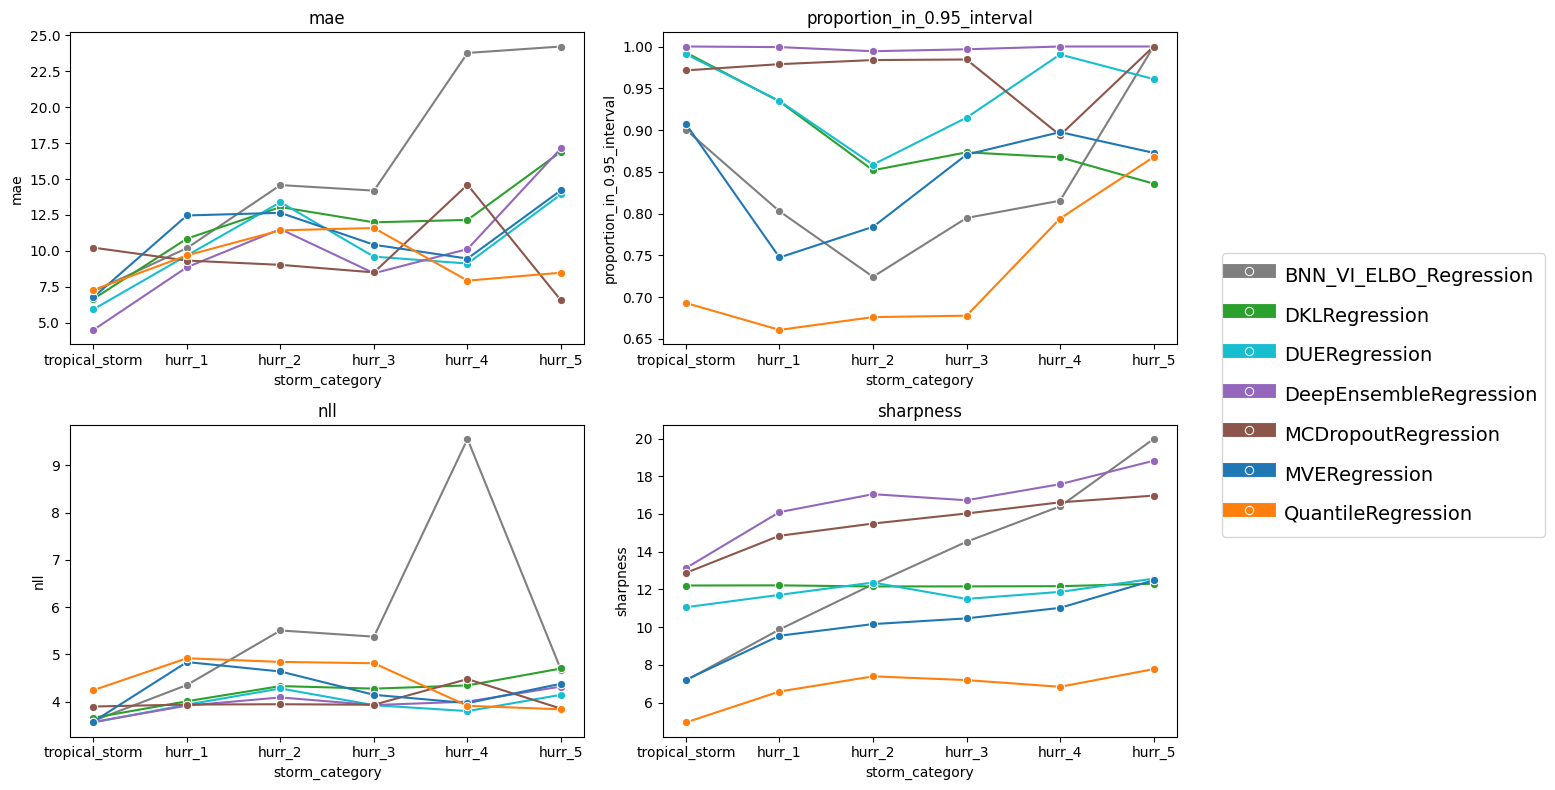

In [23]:
split = "val"

if split == "train":
    plot_cat_df = category_df[category_df["split"] == "preds_train"]
else:
    plot_cat_df = category_df[category_df["split"] == "preds_val"]
# plot per category
fig, axes = plt.subplots(2, 2, figsize=(12,8))

# Assuming 'category' is the column used for x-axis and 'metrics' are the columns to be plotted
metrics = ["mae", "proportion_in_0.95_interval", "nll", "sharpness"]

# Assuming 'methods' is the column used for hue
methods = 'u'
plot_cat_df = plot_cat_df[plot_cat_df["uqmethod"]!="DERModel"]

# Loop through the subplots
for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    
    # Create the sns plot
    sns.lineplot(x='storm_category', y=metric, hue="uqmethod", data=plot_cat_df, ax=axes[row, col], marker="o", palette=color_palette)
    
    # Add title
    axes[row, col].set_title(f'{metric}')
    
    # Add legend
    # axes[row, col].set_xticklabels(present_labels)
    # axes[row, col].legend(loc='upper right')

# set the linewidths to the copies
handles, labels = axes[0,0].get_legend_handles_labels()
[ha.set_linewidth(10) for ha in handles]

    
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.3, 0.5), fontsize=14, handleheight=2)
    
# Remove individual legends
for ax in axes.flat:
    ax.get_legend().remove()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Tables

In [24]:
uq_metric_df

,mae,rmse,mdae,marpd,r2,corr,split,pred_path,tropical_depression,tropical_storm,...,count_total,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,uqmethod
0,7.591992,9.798322,6.256293,13.166009,0.839778,0.916784,preds_val,/p/project/hai_uqmethodbox/experiment_output/k...,0,4847,...,7655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DeterministicRegression
1,1.519853,1.973517,1.224464,2.605987,0.994104,0.997178,preds_train,/p/project/hai_uqmethodbox/experiment_output/k...,0,24277,...,38934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DeterministicRegression
2,7.701325,10.256693,5.969879,13.370729,0.801679,0.895459,preds,/p/project/hai_uqmethodbox/experiment_output/k...,0,18227,...,26733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DeterministicRegression
3,8.296742,10.443477,6.965865,14.549443,0.816469,0.904652,preds_val,/p/project/hai_uqmethodbox/experiment_output/k...,0,4032,...,6265,4.423422,6.239203,3.148443,35.208731,0.217751,0.194864,0.196832,5.905790,QuantileRegression
4,4.230883,5.528176,3.383921,7.236334,0.953633,0.977113,preds_train,/p/project/hai_uqmethodbox/experiment_output/k...,0,25092,...,40324,3.060872,2.999592,1.514618,14.761082,0.012774,0.011668,0.011786,5.890229,QuantileRegression
5,8.357515,10.894114,6.804801,14.568846,0.776263,0.882358,preds,/p/project/hai_uqmethodbox/experiment_output/k...,0,18227,...,26733,4.514008,6.313677,3.185357,36.263235,0.215635,0.192843,0.194791,5.861306,QuantileRegression
6,10.102321,12.944610,8.322823,17.112713,0.683767,0.858168,preds_val,/p/project/hai_uqmethodbox/experiment_output/k...,0,5108,...,7560,3.936816,7.145963,3.608306,34.996070,0.032432,0.030112,0.030417,13.871832,MCDropoutRegression
7,5.738528,7.587897,4.437093,9.415418,0.914364,0.968241,preds_train,/p/project/hai_uqmethodbox/experiment_output/k...,0,24016,...,39029,3.640063,4.607256,2.326213,25.221888,0.220594,0.197652,0.199648,13.731698,MCDropoutRegression
8,9.623664,12.386779,7.701772,16.349122,0.710751,0.864722,preds,/p/project/hai_uqmethodbox/experiment_output/k...,0,18227,...,26733,3.876603,6.769877,3.418421,33.248626,0.047018,0.039560,0.039959,13.621179,MCDropoutRegression
9,6.832249,9.143517,5.144725,10.724730,0.880393,0.953036,preds_val,/p/project/hai_uqmethodbox/experiment_output/k...,0,3960,...,7245,3.754717,5.326558,2.689436,28.528346,0.198486,0.178582,0.180386,14.969923,DeepEnsembleRegression


In [25]:
category_columns = ["rmse", "nll"]
splits = ["Train", "Test"]

columns = pd.MultiIndex.from_product([splits, category_columns, ["default", "selective", "diff"]])
combined_df = pd.DataFrame(columns=columns)

# combined_df["uqmethod"] = tail_and_gap_selective_df["uqmethod"].unique()
for split in splits:
    if "train" in split.lower():
        table_uq_df = uq_metric_df[uq_metric_df["split"]=="preds_train"]
        table_selective_df = selective_df[selective_df["split"]=="preds_train"]
    else:
        table_uq_df = uq_metric_df[uq_metric_df["split"]=="preds_val"]
        table_selective_df = selective_df[selective_df["split"]=="preds_val"]

    table_uq_df = table_uq_df.groupby("uqmethod")[category_columns].mean().reset_index()
    table_selective_df = table_selective_df.groupby("uqmethod")[category_columns].mean().reset_index()

    for metric in category_columns:
        combined_df[(split, metric, "default")] = table_uq_df[metric]
        combined_df[(split, metric, "selective")] = table_selective_df[metric]
        combined_df[(split, metric, "diff")] = table_uq_df[metric] - table_selective_df[metric]


combined_df.insert(0, ("", "", "uqmethod"), table_uq_df["uqmethod"])
combined_df= combined_df.round(4)

def as_latex_output(combined_df):
    combined_df = combined_df.round(4)
    # print(combined_df.max())
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.4f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        # latex_column = column.replace("_", "\\_")
        # latex_output = latex_output.replace(column, latex_column)

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("diff", "diff $\downarrow$")
    latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrrrr}", "{lccc|ccc|ccc|ccc}")
    latex_output = latex_output.replace("\multicolumn{6}{r}{Train}", "\multicolumn{6}{c}{Train}")
    latex_output = latex_output.replace("\multicolumn{6}{r}{Test}", "\multicolumn{6}{c}{Test}")
    return latex_output

latex_table = as_latex_output(combined_df)
print(latex_table)

\begin{tabular}{lccc|ccc|ccc|ccc}
\toprule
 & \multicolumn{6}{c}{Train} & \multicolumn{6}{c}{Test} \\
 & \multicolumn{3}{c}{rmse} & \multicolumn{3}{c}{nll} & \multicolumn{3}{c}{rmse} & \multicolumn{3}{c}{nll} \\
uqmethod & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ \\
\midrule
\textbf{BNN\_VI\_ELBO\_Regression} & 8.0151 & 4.9150 & 3.1002 & 3.3447 & 3.0981 & 0.2466 & 12.6527 & 10.8205 & 1.8322 & 4.1956 & 4.1402 & 0.0554 \\
DKLRegression & 3.7020 & NaN & NaN & 3.4592 & NaN & NaN & 11.3041 & NaN & NaN & 3.8484 & NaN & NaN \\
DUERegression & 3.2747 & NaN & NaN & 3.3842 & NaN & NaN & 9.5560 & NaN & NaN & \textbf{3.6978} & NaN & NaN \\
DeepEnsembleRegression & 6.8510 & 1.7485 & 5.1024 & 3.6826 & 3.1132 & \textbf{0.5694} & \textbf{9.1435} & \textbf{1.9668} & \textbf{7.1767} & 3

## Metric Computation per Category

In [26]:
category_columns = ["rmse", "nll", "sharpness"]
splits = [""]

columns = pd.MultiIndex.from_product([splits, category_columns, ["default", "selective", "diff"]])
combined_df = pd.DataFrame(columns=columns)


## Error Analysis per Category

In [27]:
all_test_pred_df[all_test_pred_df["storm_category"]=="tropical_depression"]

,pred,target,uqmethod,split,pred_path,pred_uct,lower_quant,upper_quant,aleatoric_uct,epistemic_uct,target_mean,target_std,storm_category,mse,mae,nll,date


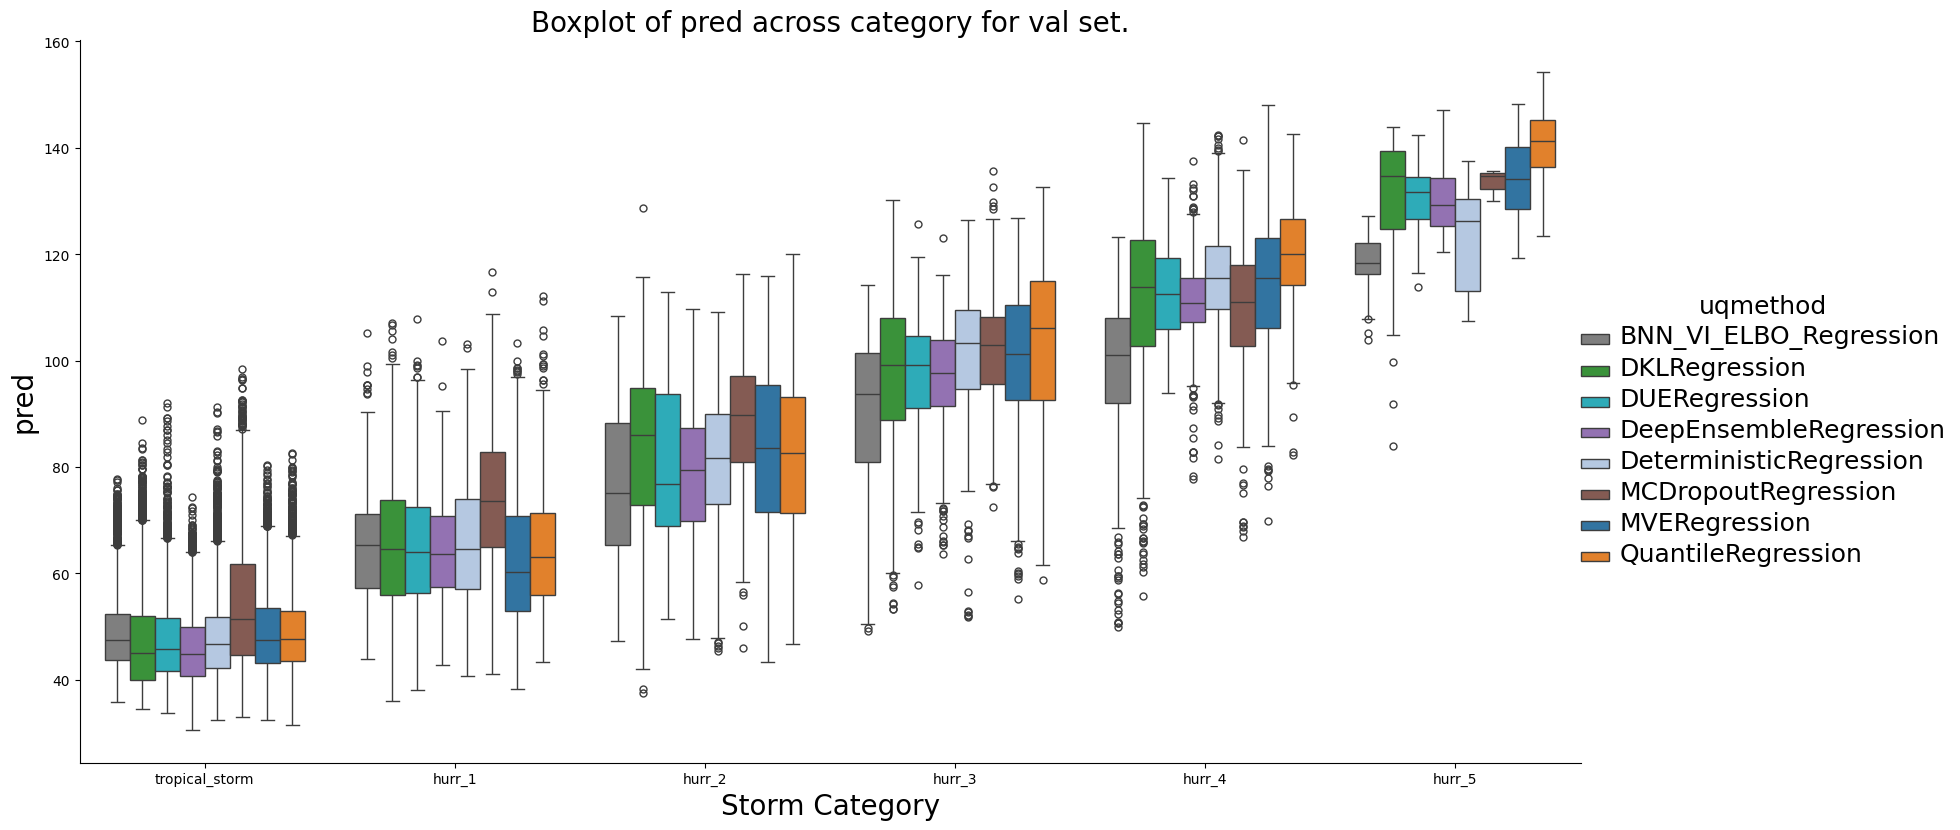

In [40]:
split = "val"
metric = "pred"
plot_df = all_test_pred_df[all_test_pred_df["split"]==f"preds_{split}.csv"]
# remove categories with no predictions
mask = plot_df.groupby("storm_category", observed=False)["mae"].transform(lambda x: x.isna().any())
plot_df = plot_df[~mask]
plot_df["storm_category"] = plot_df["storm_category"].cat.remove_unused_categories()
g = sns.catplot(plot_df, kind="box", x="storm_category", y=metric, hue="uqmethod", height=8, aspect=2, palette=color_palette)

ax = g.ax

# Add horizontal lines behind each x value group
for i, artist in enumerate(ax.artists):
    if i % 2 == 0:  # Check if it's an even index (i.e., group separator)
        artist.set_edgecolor('black')  # Set the edge color to black


# true_test_means = full_df[full_df["split"]=="test"].groupby("storm_category")["wind_speed"].mean().values
# print(true_test_means)
# pos_idx = np.linspace(0.1, 0.9, len(true_test_means))
# # Add additional horizontal lines using axhline
# for i, val in enumerate(true_test_means):
#     print(i, val)
#     ax.axhline(y=val, xmin=pos_idx[i]-0.1, xmax=pos_idx[i]+0.1, color='red', linestyle='--', linewidth=2) 

plt.title(f"Boxplot of {metric} across category for {split} set.", fontsize=20)
plt.ylabel(f"{metric}", fontsize=20)
plt.xlabel("Storm Category", fontsize=20)
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title
g._legend.set_bbox_to_anchor((1.07, 0.5))

# Selective prediction per Storm Category

In [30]:
from sklearn.metrics import mean_squared_error


split = "val"

rmse_all = all_test_pred_df[all_test_pred_df["split"]==f"preds_{split}.csv"].groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
rmse_all.columns = ['uqmethod', 'storm_category', 'RMSE_All']

# Filter data where uncertainty is less than the threshold
df_filtered = all_test_pred_df[all_test_pred_df['pred_uct'] < SELECTIVE_THRESH]

# Compute RMSE per method and category over filtered predictions
rmse_filtered = df_filtered.groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
rmse_filtered.columns = ['uqmethod', 'storm_category', 'RMSE_Uncertainty_Less_Threshold']

# Merge the two DataFrames on method and category
summary_table = pd.merge(rmse_all, rmse_filtered, on=['uqmethod', 'storm_category'], how='left')

# If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
summary_table.fillna({'RMSE_Uncertainty_Less_Threshold': np.nan}, inplace=True)

summary_table['pct_change'] = ((summary_table['RMSE_Uncertainty_Less_Threshold'] - summary_table['RMSE_All']) / summary_table['RMSE_All']) * 100
summary_table["abs_change"] = np.abs(summary_table['RMSE_Uncertainty_Less_Threshold'] - summary_table['RMSE_All'])
summary_table['abs_change'] = summary_table['abs_change'].fillna(0)


# Display the summary table
print(summary_table)

                   uqmethod  storm_category   RMSE_All  \
0    BNN_VI_ELBO_Regression  tropical_storm   8.848803   
1    BNN_VI_ELBO_Regression          hurr_1  12.260769   
2    BNN_VI_ELBO_Regression          hurr_2  17.992696   
3    BNN_VI_ELBO_Regression          hurr_3  18.705776   
4    BNN_VI_ELBO_Regression          hurr_4  29.532297   
5    BNN_VI_ELBO_Regression          hurr_5  24.516290   
6             DKLRegression  tropical_storm   8.508337   
7             DKLRegression          hurr_1  13.212279   
8             DKLRegression          hurr_2  16.439685   
9             DKLRegression          hurr_3  15.947188   
10            DKLRegression          hurr_4  16.565395   
11            DKLRegression          hurr_5  20.519598   
12            DUERegression  tropical_storm   7.693214   
13            DUERegression          hurr_1  11.893740   
14            DUERegression          hurr_2  15.590354   
15            DUERegression          hurr_3  12.249869   
16            

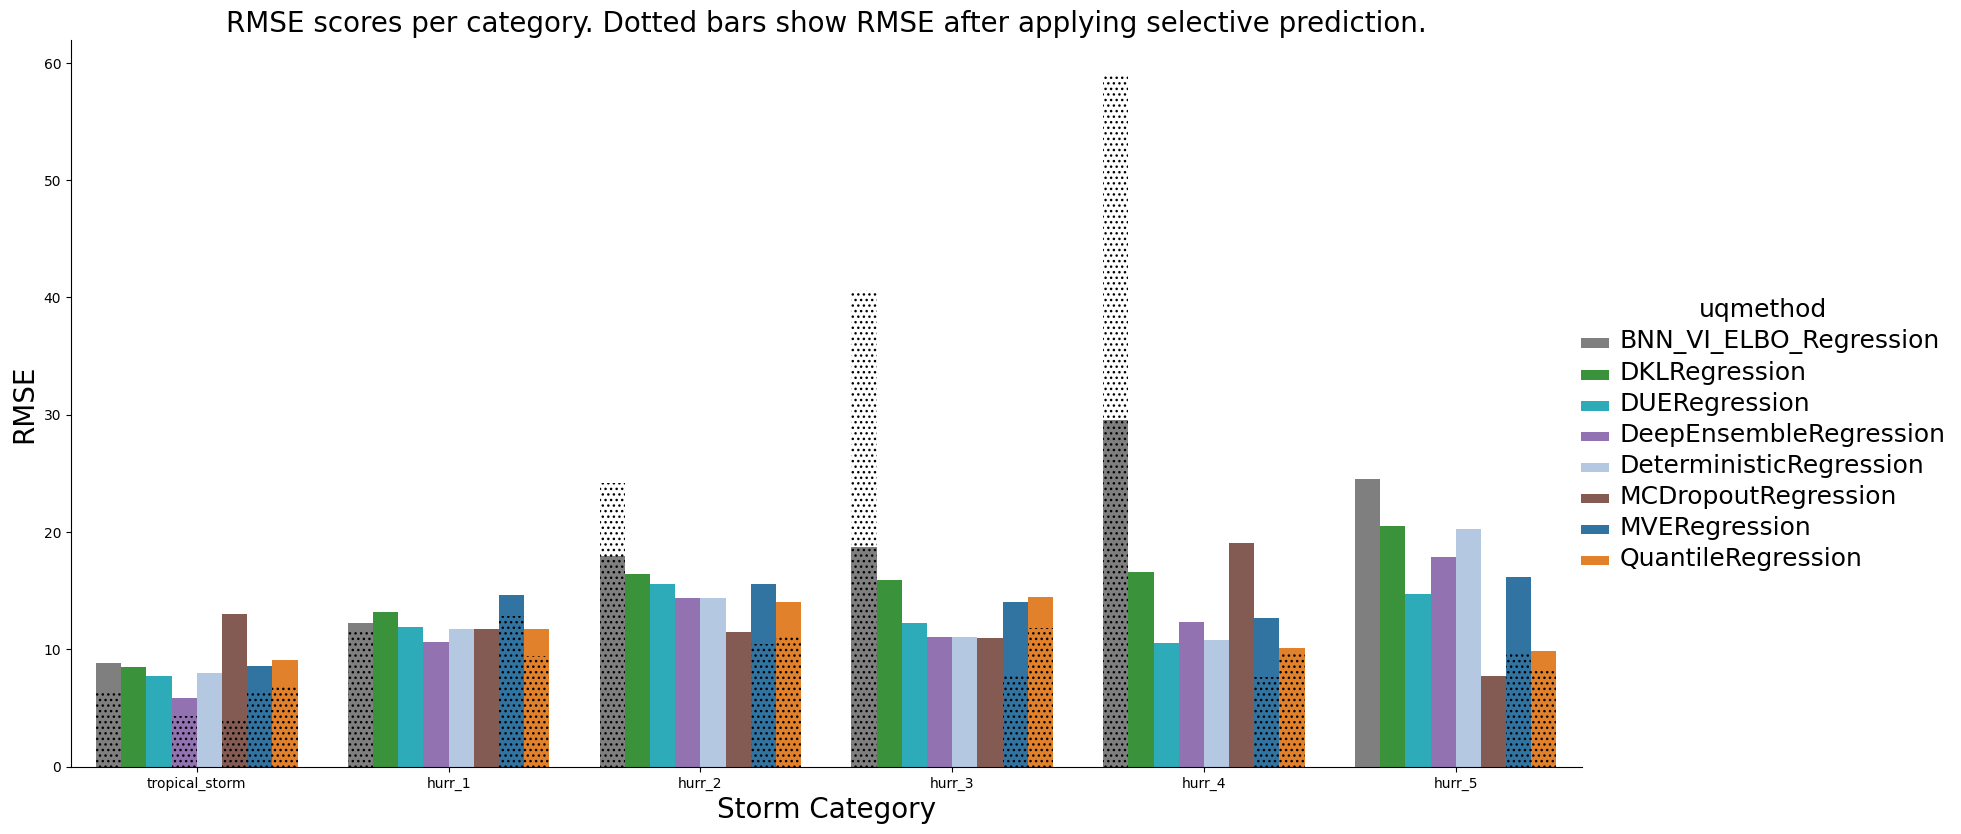

In [36]:
hue_order = summary_table["uqmethod"].unique().tolist()
# remove categories with no predictions

summary_table["storm_category"] = summary_table["storm_category"].cat.remove_unused_categories()
g = sns.catplot(summary_table, kind="bar", x="storm_category", y="RMSE_All", hue="uqmethod", height=8, aspect=2, palette=color_palette, hue_order=hue_order)

ax = g.ax

sns.barplot(summary_table, x="storm_category", y="RMSE_Uncertainty_Less_Threshold", hue="uqmethod", alpha=0.0, ax=ax, hatch="...", hue_order=hue_order)

ax.get_legend().remove()
plt.title("RMSE scores per category. Dotted bars show RMSE after applying selective prediction.", fontsize=20)
plt.ylabel("RMSE", fontsize=20)
plt.xlabel("Storm Category", fontsize=20)

plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title
g._legend.set_bbox_to_anchor((1.07, 0.5))


In [37]:
# sharpness


rmse_all = all_test_pred_df.groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.mean(x["pred_uct"])).reset_index()
rmse_all.columns = ['uqmethod', 'storm_category', 'SHARP_All']

# Filter data where uncertainty is less than the threshold
df_filtered = all_test_pred_df[all_test_pred_df['pred_uct'] < SELECTIVE_THRESH]

# Compute RMSE per method and category over filtered predictions
rmse_filtered = df_filtered.groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.mean(x["pred_uct"])).reset_index()
rmse_filtered.columns = ['uqmethod', 'storm_category', 'SHARP_Uncertainty_Less_Threshold']

# Merge the two DataFrames on method and category
summary_table = pd.merge(rmse_all, rmse_filtered, on=['uqmethod', 'storm_category'], how='left')

# If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
summary_table.fillna({'SHARP_Uncertainty_Less_Threshold': np.nan}, inplace=True)

summary_table['pct_change'] = ((summary_table['SHARP_Uncertainty_Less_Threshold'] - summary_table['SHARP_All']) / summary_table['SHARP_All']) * 100
summary_table["abs_change"] = np.abs(summary_table['SHARP_Uncertainty_Less_Threshold'] - summary_table['SHARP_All'])
summary_table['abs_change'] = summary_table['abs_change'].fillna(0)

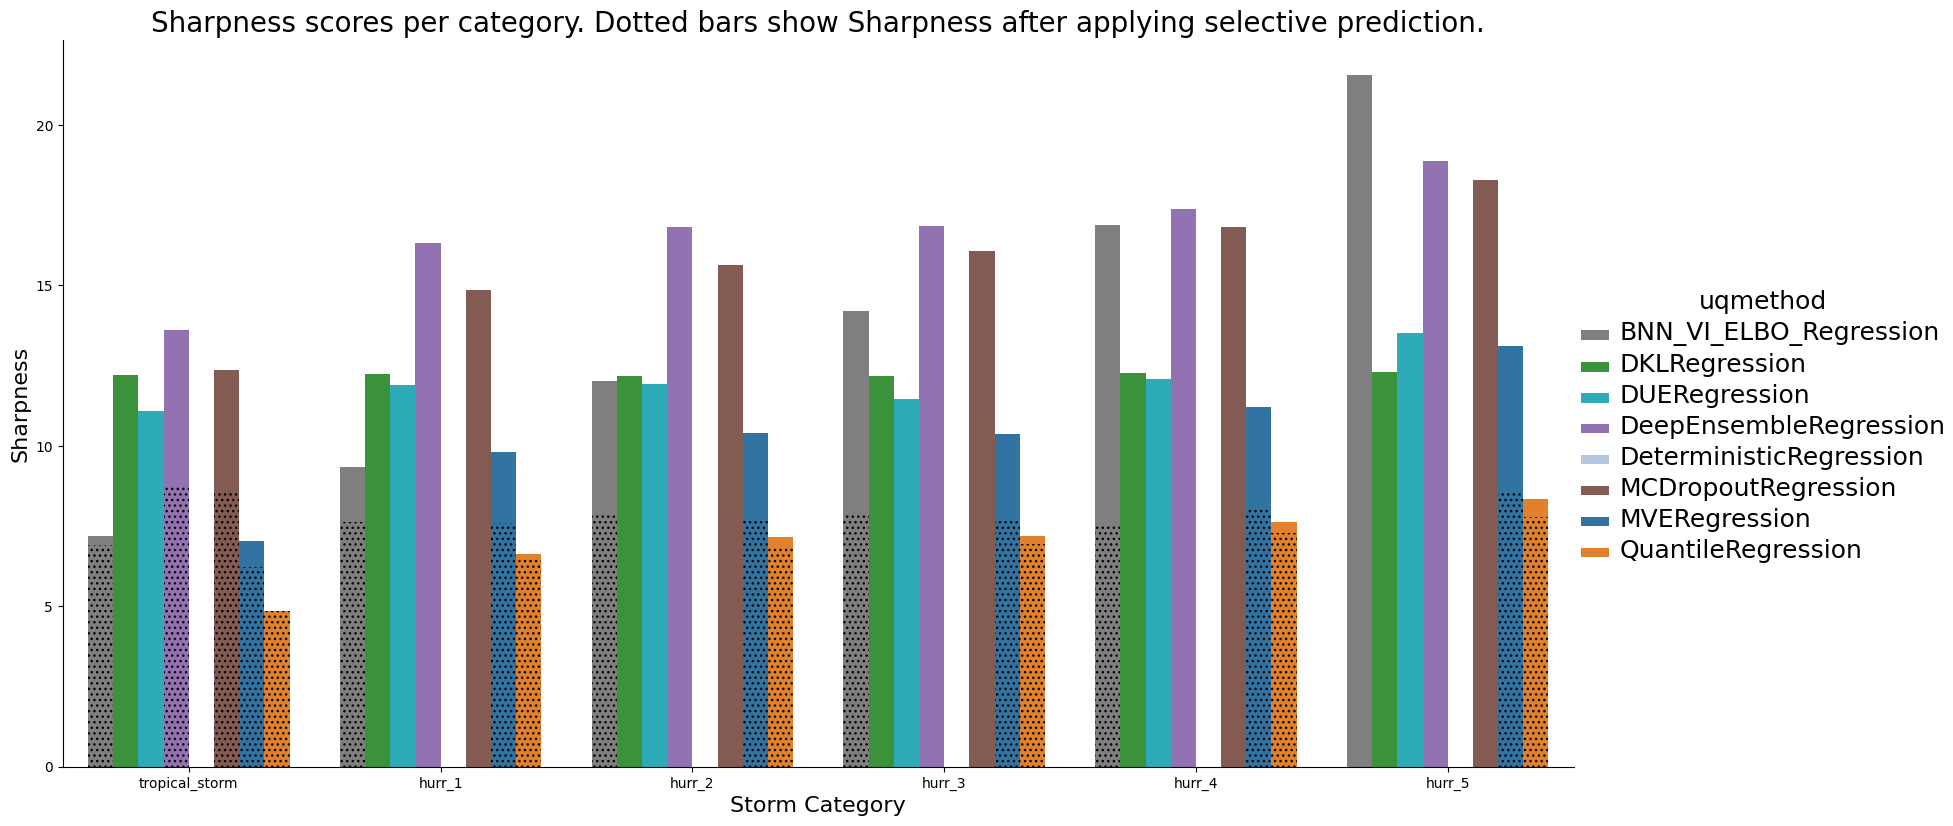

In [39]:
hue_order = summary_table[summary_table["uqmethod"]!="DERModel"]["uqmethod"].unique().tolist()
summary_table["storm_category"] = summary_table["storm_category"].cat.remove_unused_categories()
g = sns.catplot(summary_table[summary_table["uqmethod"]!="DERModel"], kind="bar", x="storm_category", y="SHARP_All", hue="uqmethod", height=8, aspect=2, palette=color_palette, hue_order=hue_order)

ax = g.ax

sns.barplot(summary_table, x="storm_category", y="SHARP_Uncertainty_Less_Threshold", hue="uqmethod", alpha=0.0, ax=ax, hatch="...", hue_order=hue_order)

ax.get_legend().remove()
plt.title("Sharpness scores per category. Dotted bars show Sharpness after applying selective prediction.", fontsize=20)
plt.ylabel("Sharpness", fontsize=16)
plt.xlabel("Storm Category", fontsize=16)
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title
g._legend.set_bbox_to_anchor((1.07, 0.5))

# Calibration

In [42]:
from typing import Union, List, Any
from matplotlib.axes import Axes
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists,
    get_proportion_lists_vectorized,
    adversarial_group_calibration,
    miscalibration_area,
    miscalibration_area_from_proportions,
)


def filter_subset(input_list: List[List[Any]], n_subset: int) -> List[List[Any]]:
    """Keep only n_subset random indices from all lists given in input_list.

    Args:
        input_list: list of lists.
        n_subset: Number of points to plot after filtering.

    Returns:
        List of all input lists with sizes reduced to n_subset.
    """
    assert type(n_subset) is int
    n_total = len(input_list[0])
    idx = np.random.choice(range(n_total), n_subset, replace=False)
    idx = np.sort(idx)
    output_list = []
    for inp in input_list:
        outp = inp[idx]
        output_list.append(outp)
    return output_list


# TODO Look up color pallete value
def plot_calibration(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    split_name: str,
    n_subset: Union[int, None] = None,
    curve_label: Union[str, None] = None,
    vectorized: bool = True,
    exp_props: Union[np.ndarray, None] = None,
    obs_props: Union[np.ndarray, None] = None,
    ax: Union[Axes, None] = None,
    prop_type: str = "interval",
) -> Axes:
    """Plot the observed proportion vs prediction proportion of outputs falling into a
    range of intervals, and display miscalibration area.

    Args:
        y_pred: 1D array of the predicted means for the held out dataset.
        y_std: 1D array of the predicted standard deviations for the held out dataset.
        y_true: 1D array of the true labels in the held out dataset.
        n_subset: Number of points to plot after filtering.
        curve_label: legend label str for calibration curve.
        vectorized: plot using get_proportion_lists_vectorized.
        exp_props: plot using the given expected proportions.
        obs_props: plot using the given observed proportions.
        ax: matplotlib.axes.Axes object.
        prop_type: "interval" to measure observed proportions for centered prediction intervals,
                   and "quantile" for observed proportions below a predicted quantile.
                   Ignored if exp_props and obs_props are provided as inputs.

    Returns:
        matplotlib.axes.Axes object with plot added.
    """
    # Create ax if it doesn't exist
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true] = filter_subset([y_pred, y_std, y_true], n_subset)

    if (exp_props is None) or (obs_props is None):
        # Compute exp_proportions and obs_proportions
        if vectorized:
            (exp_proportions, obs_proportions) = get_proportion_lists_vectorized(
                y_pred, y_std, y_true, prop_type=prop_type
            )
        else:
            (exp_proportions, obs_proportions) = get_proportion_lists(
                y_pred, y_std, y_true, prop_type=prop_type
            )
    else:
        # If expected and observed proportions are given
        exp_proportions = np.array(exp_props).flatten()
        obs_proportions = np.array(obs_props).flatten()
        if exp_proportions.shape != obs_proportions.shape:
            raise RuntimeError("exp_props and obs_props shape mismatch")

    # Set label
    if curve_label is None:
        curve_label = "Predictor"

    # Plot
    ax.plot([0, 1], [0, 1], "--", c="gray")
    ax.plot(
        exp_proportions, obs_proportions, label=curve_label.replace("Model", ""), c=color_palette[curve_label]
    )  # , c="#1f77b4")
    # ax.fill_between(exp_proportions, exp_proportions, obs_proportions, alpha=0.1)

    # Format plot
    ax.set_xlabel("Predicted Proportion in Interval", fontsize=16)
    ax.set_ylabel("Observed Proportion in Interval", fontsize=16)
    ax.axis("square")

    buff = 0.01
    ax.set_xlim([0 - buff, 1 + buff])
    ax.set_ylim([0 - buff, 1 + buff])

    ax.set_title(f"Avg Calibration {split_name}", fontsize=16)

    # Compute miscalibration area
    miscalibration_area = miscalibration_area_from_proportions(
        exp_proportions=exp_proportions, obs_proportions=obs_proportions
    )

    # Annotate plot with the miscalibration area
    # ax.text(
    #     x=0.95,
    #     y=0.05,
    #     s="Miscalibration area = %.2f" % miscalibration_area,
    #     verticalalignment="bottom",
    #     horizontalalignment="right",
    #     fontsize="small",
    # )

    return ax

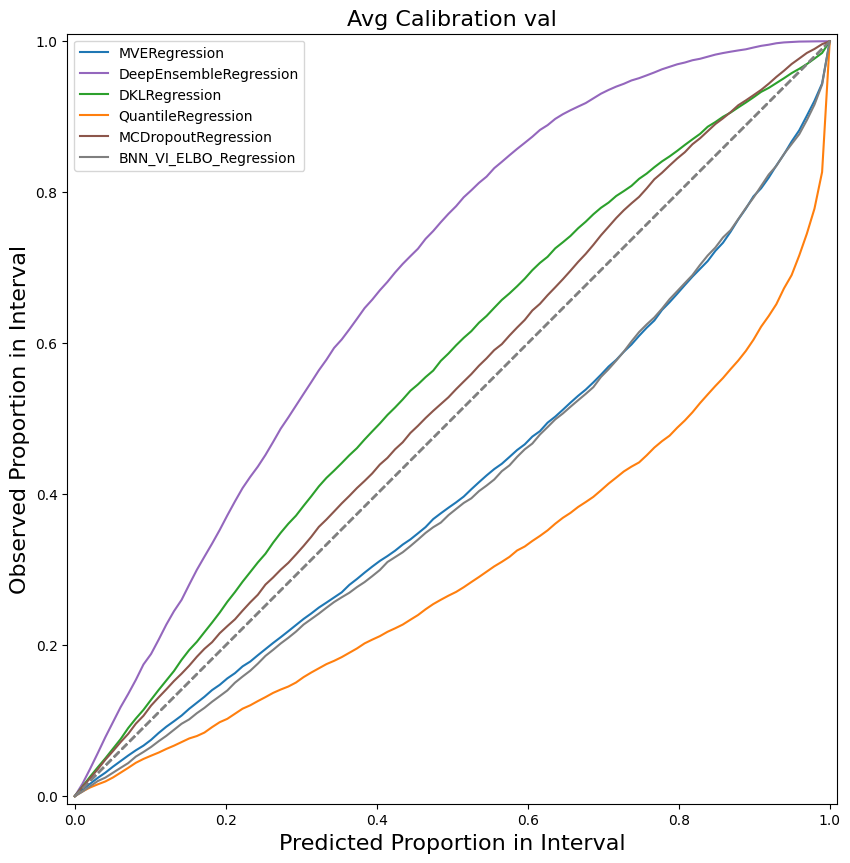

In [44]:
uq_methods_to_show = [
    "MVERegression",
    "DeepEnsembleRegression",
    "DKLRegression",
    "LaplaceRegression",
    "ConformalQR",
    "QuantileRegression",
    "MCDropoutRegression",
    "SWAGRegression",
    "BNN_VI_ELBO_Regression",
    "DER",
]

split = "val"

fig, axs = plt.subplots(1, figsize=(10,10))
for idx_uq, uq_method in enumerate(uq_methods_to_show):
    plot_df = uq_metric_df[uq_metric_df["uqmethod"] == uq_method].copy()
    if split == "train":
        plot_df = plot_df[plot_df["split"]=="preds_train"]
    else:
        plot_df = plot_df[plot_df["split"]=="preds_val"]
    plot_df.sort_values(by="split", inplace=True)
    plot_df.reset_index(inplace=True)
    # for idx, pred_path in enumerate(plot_df["pred_path"].unique()):
    for idx, row in plot_df.iterrows():
        split_df = pd.read_csv(row["pred_path"])
        if "pred_uct" in split_df.columns:
            plot_calibration(
                split_df["pred"].values.squeeze(),
                split_df["pred_uct"].values.squeeze(),
                split_df["target"].values.squeeze(),
                ax=axs,
                curve_label=uq_method,
                split_name=split
            )
plt.legend()

# Data Exploration

In [ ]:
from tropical_cyclone_ds import TropicalCycloneSequence

path = "/p/project/hai_uqmethodbox/data/tropical_cyclone"

train_ds = TropicalCycloneSequence(root=path)

Num samples: 69269


In [ ]:
for i in range(len(train_ds)):
    sample = train_ds[i]
    if int(sample["wind_speed"]) > 0:
        train_ds.plot(sample)
        break
# train_ds[0].keys()

In [ ]:
def retrieve_item(item, ds):
    source_id = item["href"].split("/")[0]
    if "train_source" in source_id:
        split = "train"
    else:
        split = "test"

    directory = os.path.join(
        ds.root,
        "_".join([train_ds.collection_id, split, "{0}"]),
        source_id.replace("source", "{0}"),
    )
    features = ds._load_features(directory)
    data = {"path": source_id, **features}
    # don't nee the tensor label, already includes 'wind_speed'
    data.pop("label")
    # but add original split where it is coming from
    data["split"] = split
    return data

def retrieve_collection_df(ds):
    def parallel_process(items, ds, num_processes: int):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        read_items = pool.starmap(retrieve_item, [(item, ds) for item in items])
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        df = pd.DataFrame.from_dict(read_items)
        return df
    
    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities
    items = [item for item in ds.collection]
    # Call the parallel_process function to execute the processing in parallel
    df = parallel_process(items, ds, num_processes)

    return df

In [ ]:
train_df = retrieve_collection_df(train_ds)
test_df = retrieve_collection_df(test_ds)

In [ ]:
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df["wind_speed"] = full_df["wind_speed"].astype(int)

full_df['storm_category'] = pd.cut(full_df['wind_speed'], bins=bins, labels=labels, right=False)
full_df
                     

## Wind Speed across splits

In [ ]:
fig, axs = plt.subplots(1)
sns.violinplot(full_df, x="split", y="wind_speed", ax=axs)
axs.set_title("Wind Speed for train and test split.")

## Wind Speed across categories

In [ ]:
# fig, axs = plt.subplots(1)
sns.catplot(full_df, kind="box", x="storm_category", y="wind_speed", hue="split")
plt.title("Boxplot of wind speeds across category and split")

In [ ]:
fig, axs = plt.subplots(1)
sns.countplot(full_df, x="storm_category", hue="split", ax=axs)
plt.title("Count samples per storm category")

In [ ]:
train_df["wind_speed"].astype(int).values

In [ ]:
from denseweight import DenseWeight
import numpy as np
import torch

target = (train_df["wind_speed"].astype(float).values - TARGET_MEAN) / TARGET_STD
dw = DenseWeight(alpha=1.0)
weights = dw.fit(target)


curr_weight = dw(torch.Tensor([0.1]))
type(curr_weight)


In [ ]:
np.save("/p/project/hai_uqmethodbox/nils/lightning-uq-box/experiments/image-regression/configs/tropical_cyclone/target.npy", (train_df["wind_speed"].astype(float).values - TARGET_MEAN) / TARGET_STD)